# Biomedical Image Segmentation with U-Net

In this code example, we apply the U-Net architecture to segment brain tumors from raw MRI scans as shown below. With relatively little data we are able to train a U-Net model to accurately predict where tumors exist. 

The Dice coefficient (the standard metric for the BraTS dataset used in the study) for our model is about 0.82-0.88.  Menze et al. [reported](http://ieeexplore.ieee.org/document/6975210/) that expert neuroradiologists manually segmented these tumors with a cross-rater Dice score of 0.75-0.85, meaning that the model’s predictions are on par with what expert physicians have made.

<img src="images/figure1.png">

Since its introduction two years ago, the [U-Net](https://arxiv.org/pdf/1505.04597.pdf0) architecture has been used to create deep learning models for segmenting [nerves](https://github.com/jocicmarko/ultrasound-nerve-segmentation) in ultrasound images, [lungs](https://www.kaggle.com/c/data-science-bowl-2017#tutorial) in CT scans, and even [interference](https://github.com/jakeret/tf_unet) in radio telescopes.

## What is U-Net?
U-Net is designed like an [auto-encoder](https://en.wikipedia.org/wiki/Autoencoder). It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. For each pixel in the original image, it asks the question: “To which class does this pixel belong?” This flexibility allows U-Net to predict different parts of the tumor simultaneously.

<img src="images/unet.png">

This module loads the data from `data.py`, creates a TensorFlow/Keras model from `model.py`, trains the model on the data, and then saves the best model.

In [2]:
import tensorflow as tf 
import datetime
import time
import os
from IPython.display import Image
import settings    # Use the custom settings.py file for default parameters
import onnxmltools

import sys; sys.argv=['']; del sys
from model import load_model, get_callbacks, evaluate_model
from data import load_data

from argparser import args

if args.keras_api:
    import keras as K
else:
    from tensorflow import keras as K

print ("We are using Tensorflow version", tf.__version__,\
       "with Intel(R) MKL", "enabled" if tf.pywrap_tensorflow.IsMklEnabled() else "disabled",)

onnx = False # Set whether we are exporting to ONNX model and using nGraph

Data format = channels_last
We are using Tensorflow version 1.12.0 with Intel(R) MKL enabled


Using TensorFlow backend.


For best CPU speed set the number of intra and inter threads to take advantage of multi-core systems.
See https://github.com/intel/mkl-dnn

In [3]:
#TODO: Set the multi-threading parameters for Tensorflow. 
config = tf.ConfigProto(intra_op_parallelism_threads=args.num_threads,
                        inter_op_parallelism_threads=args.num_inter_threads)

sess = tf.Session(config=config)

K.backend.set_session(sess)

## Training Time!

The bulk of the training section can be broken down in 4 simple steps:
1. Load the training data
1. Define the model
3. Train the model on the data
4. Evaluate the best model
    

#### Step 1 : Loading the data

In [4]:
hdf5_filename = os.path.join(args.data_path, args.data_filename)
print("-" * 30)
print("Loading the data from HDF5 file ...")
print("-" * 30)

imgs_train, msks_train, imgs_validation, msks_validation = load_data(hdf5_filename)

print("-" * 30)
print("Creating and compiling model ...")
print("-" * 30)

/opt/anaconda/envs/idp/lib/python3.6/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


------------------------------
Loading the data from HDF5 file ...
------------------------------
Batch size = 128
Training image dimensions:   (58464, 144, 144, 4)
Training mask dimensions:    (58464, 144, 144, 1)
Validation image dimensions: (11232, 144, 144, 4)
Validation mask dimensions:  (11232, 144, 144, 1)
------------------------------
Creating and compiling model ...
------------------------------


#### Step 2: Define the model

Using UpSampling2D
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MRImages (InputLayer)           (None, 144, 144, 4)  0                                            
__________________________________________________________________________________________________
encodeAa (Conv2D)               (None, 144, 144, 32) 1184        MRImages[0][0]                   
__________________________________________________________________________________________________
encodeAb (Conv2D)               (None, 144, 144, 32) 9248        encodeAa[0][0]                   
__________________________________________________________________________________________________
poolA (MaxPooling2D)            (None, 72, 72, 32)   0           encodeAb[0][0]                   
__________________________________________________________________________________________

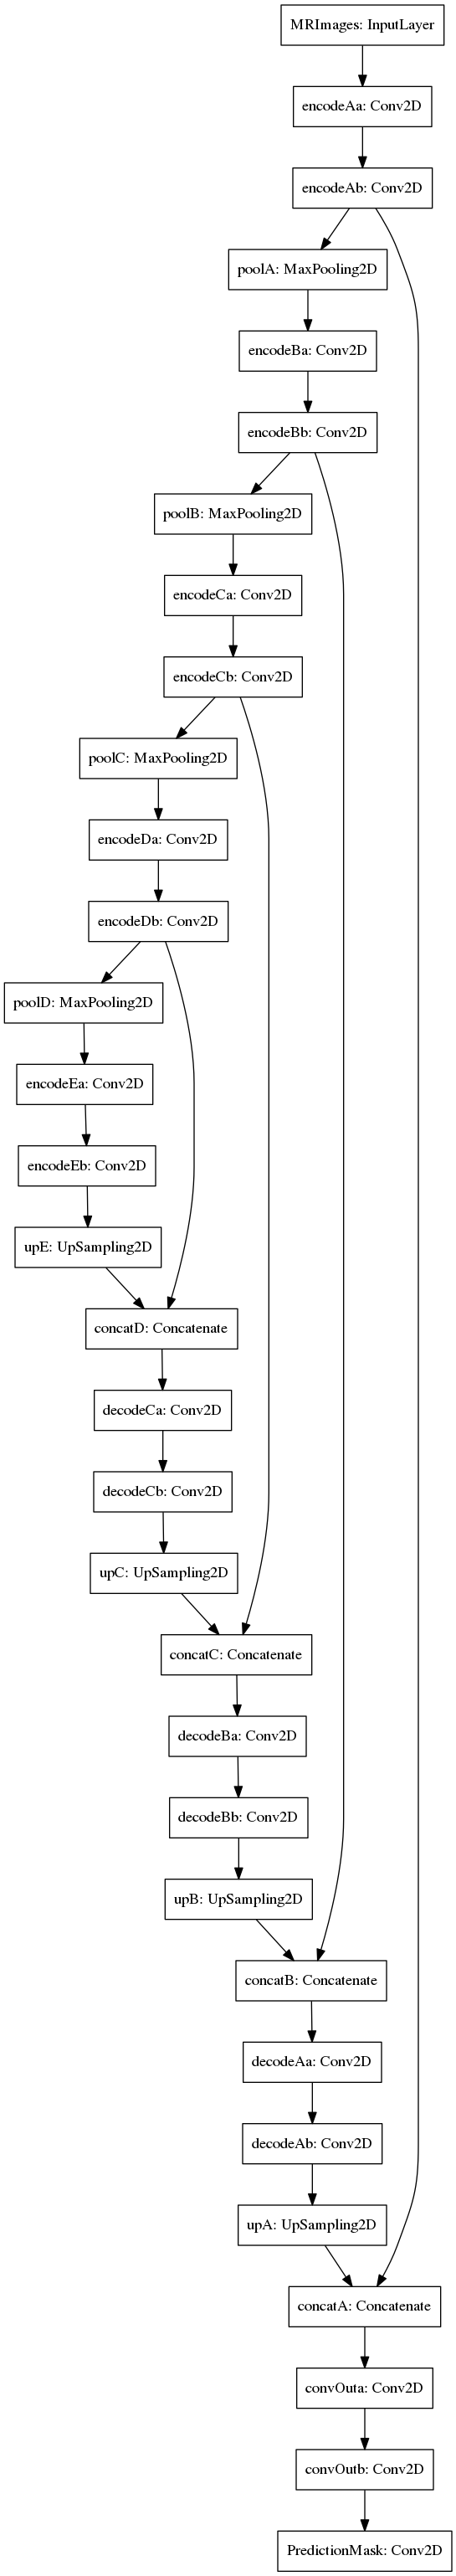

In [5]:
model = load_model(imgs_train.shape, msks_train.shape)
model_filename, model_callbacks = get_callbacks()

The code snippet below draws the model using Keras' built-in `plot_model`. Compare with the implementation of `model.py`

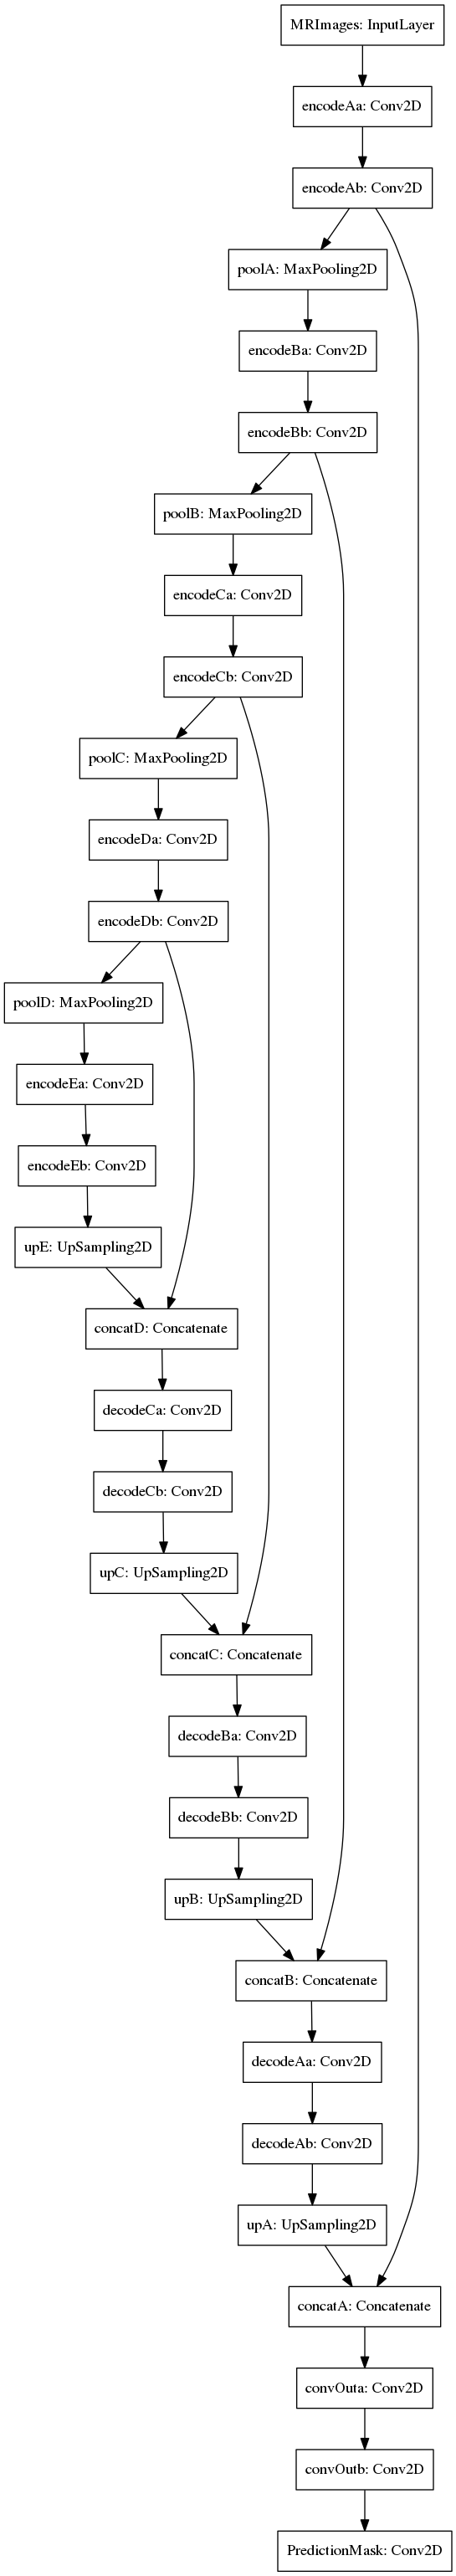

In [9]:
tf.keras.utils.plot_model(model,
                          to_file='images/model.png',
                          show_shapes=False,
                          show_layer_names=True,
                          rankdir='TB'
                         )
Image('images/model.png')

#### Step 3: Train the model on the data

In [ ]:
print("-" * 30)
print("Fitting model with training data ...")
print("-" * 30)

print("Step 3, training the model started at {}".format(datetime.datetime.now()))
start_time = time.time()

if onnx:
    for i in range(0,30):
        print ("Processing batch:", i)
        start_time = time.time()
        model.train_on_batch(imgs_train[i*args.batch_size:args.batch_size*(i+1)-1], \
                             msks_train[i*args.batch_size:args.batch_size*(i+1)-1])
        print ("Time for training on batch:", time.time() - start_time) 

        # TODO: Convert the Keras model to ONNX and save it. 
        onnx_model = onnxmltools.convert_keras(model, target_opset=7) 
        onnxmltools.utils.save_model(onnx_model, 'output/unet_model_for_decathlon.onnx')
else:
    history = model.fit(imgs_train, msks_train,
                        batch_size=args.batch_size,
                        epochs=args.epochs,
                        validation_data=(imgs_validation, msks_validation),
                        verbose=1, shuffle="batch",
                        callbacks=model_callbacks)
    
print("Total time elapsed for training = {} seconds".format(time.time() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))
    
# Append training log
# with open("training.log","a+") as fp:
#     fp.write("{}: {}\n".format(datetime.datetime.now(),
#                              history.history["val_dice_coef"]))


#### Step 4: Evaluate the best model

In [ ]:
print("-" * 30)
print("Loading the best trained model ...")
print("-" * 30)
model = evaluate_model(model_filename, imgs_validation, msks_validation)

## End: In this tutorial, you have learnt:
* What is the U-Net model
* Comparing training times - Tensorflow_MKLDNN vs Tensorflow (stock)
* How to tweak a series of environment variables to get better performance out of MKLDNN
* How to tweak a series of Tensorflow-related and neural-network specific parameters for better performance

`Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0`